In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 94% 313M/331M [00:05<00:00, 115MB/s] 
100% 331M/331M [00:05<00:00, 68.2MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip", 'r')
zip.extractall("/content")
zip.close()

In [4]:
import os
import numpy as ny
import pandas as ps
from keras.preprocessing.image import ImageDataGenerator

In [5]:
folderPath = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
age = []
gender = []
imgPath = []
for file in os.listdir(folderPath):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  imgPath.append(file)

In [7]:
len(age)

23708

In [8]:
dF = ps.DataFrame({'age':age, 'gender':gender, 'img':imgPath})

In [9]:
dF.shape

(23708, 3)

In [10]:
dF.head()

,age,gender,img
0,35,1,35_1_0_20170117170842874.jpg.chip.jpg
1,14,1,14_1_0_20170104005937407.jpg.chip.jpg
2,3,0,3_0_2_20161219142551561.jpg.chip.jpg
3,38,1,38_1_3_20170104214200582.jpg.chip.jpg
4,39,1,39_1_1_20170116160927002.jpg.chip.jpg


In [11]:
traindF = dF.sample(frac = 1, random_state = 0).iloc[:20000]
testdF = dF.sample(frac = 1, random_state = 0).iloc[20000:]

In [12]:
traindF.shape, testdF.shape

((20000, 3), (3708, 3))

In [13]:
trainDG = ImageDataGenerator(rescale = 1/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
testDG = ImageDataGenerator(rescale = 1./255)

In [14]:
trainGenerator = trainDG.flow_from_dataframe(traindF, directory = folderPath, x_col = 'img',  y_col = ['age', 'gender'], target_size = (200, 200), class_mode = 'multi_output')
testGenerator = testDG.flow_from_dataframe(testdF, directory = folderPath, x_col = 'img',  y_col = ['age', 'gender'], target_size =  (200, 200), class_mode = 'multi_output')


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [15]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [16]:
vggNET = VGG16(include_top = False, input_shape = (200, 200, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
vggNET.trainable = False

output = vggNET.layers[-1].output
flatten = Flatten()(output)

dense1 = Dense(512, activation = 'relu')(flatten)
dense2 = Dense(512, activation = 'relu')(flatten)

dense3 = Dense(512, activation = 'relu')(dense1)
dense4 = Dense(512, activation = 'relu')(dense2)

output1 = Dense(1, activation = 'linear', name = 'age')(dense3)
output2 = Dense(1, activation = 'sigmoid', name = 'gender')(dense4)


In [18]:
model = Model(inputs = vggNET.input, outputs = [output1, output2])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

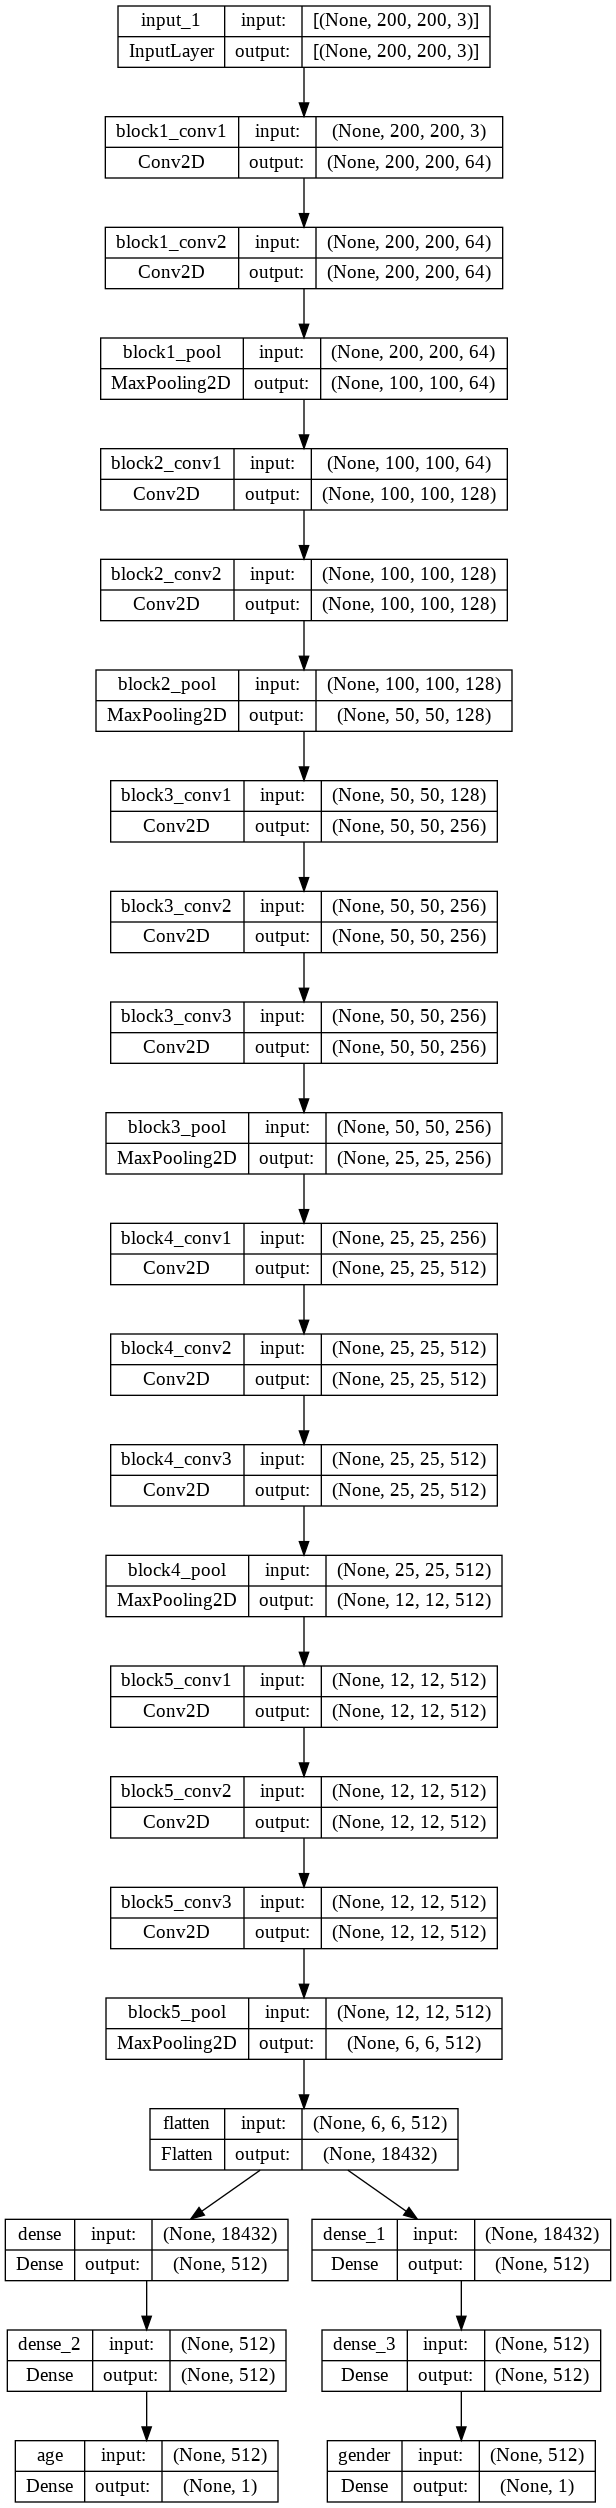

In [19]:
from keras.utils import plot_model
plot_model(model, show_shapes = True)

In [20]:
model.compile(optimizer = 'adam', loss = {'age': 'mae', 'gender': 'binary_crossentropy'}, metrics = {'age': 'mae', 'gender': 'accuracy'}, loss_weights = {'age':1, 'gender':99})
traininglog = model.fit(trainGenerator, batch_size = 32, epochs = 10, validation_data = testGenerator)

Epoch 1/10
625/625 [==============================] - 230s 351ms/step - loss: 62.7571 - age_loss: 11.0257 - gender_loss: 0.5225 - age_mae: 11.0257 - gender_accuracy: 0.7473 - val_loss: 44.2956 - val_age_loss: 9.1411 - val_gender_loss: 0.3551 - val_age_mae: 9.1411 - val_gender_accuracy: 0.8409
Epoch 2/10
625/625 [==============================] - 216s 346ms/step - loss: 52.3051 - age_loss: 9.4518 - gender_loss: 0.4329 - age_mae: 9.4518 - gender_accuracy: 0.7970 - val_loss: 41.1911 - val_age_loss: 8.0831 - val_gender_loss: 0.3344 - val_age_mae: 8.0831 - val_gender_accuracy: 0.8501
Epoch 3/10
625/625 [==============================] - 215s 344ms/step - loss: 50.3942 - age_loss: 9.0493 - gender_loss: 0.4176 - age_mae: 9.0493 - gender_accuracy: 0.8018 - val_loss: 39.9635 - val_age_loss: 8.2688 - val_gender_loss: 0.3201 - val_age_mae: 8.2688 - val_gender_accuracy: 0.8541
Epoch 4/10
625/625 [==============================] - 214s 343ms/step - loss: 49.2102 - age_loss: 8.8939 - gender_loss: 0.

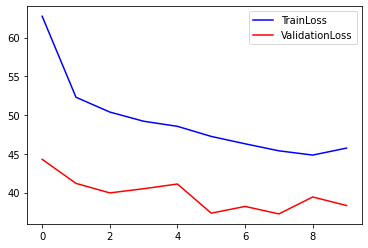

In [23]:
import matplotlib.pyplot as plt

plt.plot(traininglog.history['loss'], color = 'blue', label = 'TrainLoss')
plt.plot(traininglog.history['val_loss'], color = 'red', label = 'ValidationLoss')
plt.legend()
plt.show()

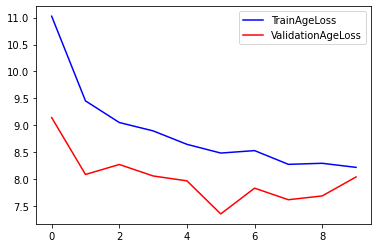

In [27]:
plt.plot(traininglog.history['age_loss'], color = 'blue', label = 'TrainAgeLoss')
plt.plot(traininglog.history['val_age_loss'], color = 'red', label = 'ValidationAgeLoss')
plt.legend()
plt.show()

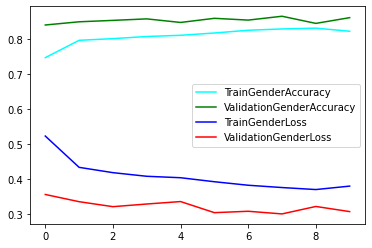

In [31]:
plt.plot(traininglog.history['gender_accuracy'], color = 'cyan', label = 'TrainGenderAccuracy')
plt.plot(traininglog.history['val_gender_accuracy'], color = 'green', label = 'ValidationGenderAccuracy')
plt.plot(traininglog.history['gender_loss'], color = 'blue', label = 'TrainGenderLoss')
plt.plot(traininglog.history['val_gender_loss'], color = 'red', label = 'ValidationGenderLoss')
plt.legend()
plt.show()